In [1]:
!pip install torch

In [3]:
import os
import numpy as np
import time
from pathlib import Path
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from PIL import Image

# Grounding DINO
#import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import load_image, predict

# segment anything
from segment_anything import build_sam, SamPredictor 
import matplotlib.pyplot as plt

# diffusers
import shutil

from huggingface_hub import hf_hub_download

#implementation from: https://github.com/IDEA-Research/GroundingDINO. Follow directions from that github for environment setup / dependencies / use

/Users/hankg/anaconda3/envs/autodist_env3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/hankg/Desktop/MountainMappingProj/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model  

In [5]:
# Use this command for evaluate the Grounding DINO model (got from)
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [6]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased
Model loaded from /Users/hankg/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
sam_checkpoint = "/Users/hankg/Downloads/sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)
model_type = "vit_h"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [9]:
directory_path = "./training_images"  # Replace with your directory path
out_label_path = "training_data/labels"
out_image_path = "training_data/images"

#CHECK IT OUTPUT PATHS EXIST
if os.path.isdir(out_label_path) == 0:
    os.mkdir(out_label_path)
if os.path.isdir(out_image_path) == 0:
    os.mkdir(out_image_path)

In [14]:
start_total = time.time()
print(f"segmenting {len(os.listdir(directory_path))} images")
for images in os.listdir(directory_path):
    start = time.time()
    print(images)
    # check if the image ends with png
    #GET ALL IMAGES
    if (images.endswith(".jpg")):
       
        input_file_path = directory_path+"/"+images
        output_file_mask_path = out_label_path+"/"+Path(input_file_path).stem+"_mask.jpg"
        output_file_image_path = out_image_path+"/"+images
    
        
        if os.path.exists(output_file_mask_path)==0:        
            try:
                #check if file exists
                if os.path.exists(output_file_image_path) == 0:
                    # Copy the file if not
                    shutil.copyfile(input_file_path, output_file_image_path)
                    print(f"File '{input_file_path}' copied to '{out_image_path}' successfully.")
                else:
                    print(f"File '{images}' already copied to '{out_image_path}' successfully.")
            except FileNotFoundError:
                print(f"Error: Source file '{source_file}' not found.")
            except Exception as e:
                print(f"An error occurred: {e}")
                
            local_image_path = output_file_image_path
            image_source, image = load_image(local_image_path)
        
            TEXT_PROMPT = 'mountain'
        
            BOX_TRESHOLD = 0.225
            TEXT_TRESHOLD = 0.225
            
            boxes, logits, phrases = predict(
                model=groundingdino_model, 
                image=image, 
                caption=TEXT_PROMPT, 
                box_threshold=BOX_TRESHOLD, 
                text_threshold=TEXT_TRESHOLD,
                device=DEVICE
            )
        
            sam_predictor.set_image(image_source)
            
            # box: normalized box xywh -> unnormalized xyxy
            H, W, _ = image_source.shape
            boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
        
            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
            masks, _, _ = sam_predictor.predict_torch(
                        point_coords = None,
                        point_labels = None,
                        boxes = transformed_boxes,
                        multimask_output = False,
                    )
            
            np_mask = masks.cpu().detach().numpy()[0][0].astype(np.uint8)
            
            mask_image = Image.fromarray(np_mask)
            mask_image.save(output_file_mask_path)
            
            end = time.time()
            print(f"time for masking {images} was {((end-start)/60)} minutes")
            print(f"{images} was segmented!")
        else:
            print(f"{images} already segmented, mask found at {output_file_mask_path}")
    else:
        print("no image")

end_total = time.time()
print(f"total time for {len(os.listdir(directory_path))} images was {(end_total-start_total)/60} minutes")

segmenting 2 images
image1.jpg
File './training_images/image1.jpg' copied to 'training_data/images' successfully.


time for masking image1.jpg was 2.4037598848342894 minutes
image1.jpg was segmented!
total time for 1 images was 2.404167449474335 minutes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..1.7511113].


(-0.5, 5374.5, 3582.5, -0.5)

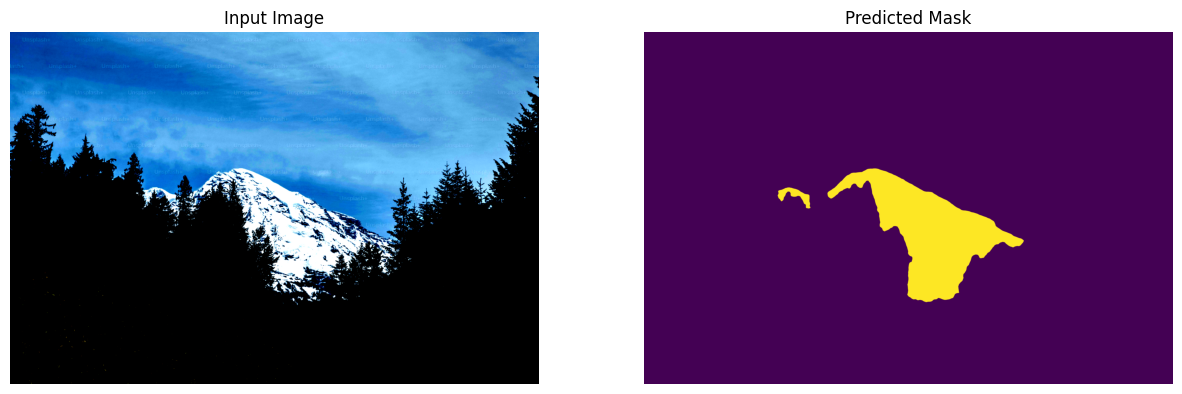

In [27]:
np_mask = np_mask.astype(np.uint8)

display_list = [image, np_mask]
plt.figure(figsize=(15, 15))

title = ['Input Image', 'Predicted Mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0)) #permute to plot torch image
plt.title(title[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Image.fromarray(np_mask))
plt.title(title[1])
plt.axis('off')